In [96]:
import numpy as np
from ctapipe.io.eventsourcefactory import EventSourceFactory
from ctapipe.calib import CameraCalibrator
from ctapipe.image.hillas import hillas_parameters, HillasParameterizationError
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.reco import HillasReconstructor
import astropy.units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
from collections import namedtuple, Counter
from astropy.coordinates.angle_utilities import angular_separation

from tqdm import tqdm
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
names_to_id = {'LSTCam': 1, 'NectarCam': 2, 'FlashCam': 3, 'DigiCam': 4, 'CHEC': 5}
types_to_id = {'LST': 1, 'MST': 2, 'SST': 3}
allowed_cameras = ['LSTCam', 'NectarCam', 'DigiCam']
allowed_tel_ids = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194]

SubMomentParameters = namedtuple('SubMomentParameters', 'size,cen_x,cen_y,length,width,psi')

In [111]:
import warnings
from astropy.utils.exceptions import AstropyDeprecationWarning
# do some horrible things to silence warnings in ctapipe
warnings.filterwarnings('ignore', category=AstropyDeprecationWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
np.warnings.filterwarnings('ignore')

def direction(event):
    reco = HillasReconstructor()
    
    features = {}
    params = {}
    pointing_azimuth = {}
    pointing_altitude = {}
    
    counter = Counter
    for telescope_id, dl1 in event.dl1.tel.items():
        camera = event.inst.subarray.tels[telescope_id].camera

        mask = tailcuts_clean(camera, dl1.image[0], boundary_thresh=5, picture_thresh=10)
        telescope_type_name = event.inst.subarray.tels[telescope_id].optics.tel_type
        
        image = dl1.image[0].copy()
        image[~mask] = 0
        
        h = hillas_parameters(
            camera,
            image,
            container=True
        )
        
        # the data in each event has to be put inside these namedtuples to call reco.predict
        moments = SubMomentParameters(size=h.intensity, cen_x=h.x, cen_y=h.y, length=h.length, width=h.width, psi=h.psi )
        params[telescope_id] = moments
        pointing_azimuth[telescope_id] = event.mc.tel[telescope_id].azimuth_raw * u.rad
        pointing_altitude[telescope_id] = ((np.pi/2) - event.mc.tel[telescope_id].altitude_raw )* u.rad
        

    reconstruction = reco.predict(params, event.inst, pointing_azimuth, pointing_altitude)
    d = {
        'mc_alt': event.mc.alt.rad,
        'mc_az': event.mc.az.rad,
        'mc_core_x': event.mc.core_x.value,
        'mc_core_y': event.mc.core_y.value,
        'mc_height_first_interaction': event.mc.h_first_int.value,
        'alt_prediction': reconstruction.alt.si.value,
        'az_prediction': reconstruction.az.si.value,
        'core_x_prediction': reconstruction.core_x.value,
        'core_y_prediction': reconstruction.core_y.value,
        'h_max_prediction': reconstruction.h_max.value,
    }
    return d
    
def strip_unit(v):
    try:
        return v.si.value
    except AttributeError:
        return v

In [112]:
def analyze_file(input_file, allowed_tel_ids, n_events=-1):
    event_source = EventSourceFactory.produce(
        input_url=input_file,
        max_events=n_events if n_events > 1 else None,
        allowed_tels=allowed_tel_ids
    )

    calibrator = CameraCalibrator(
        eventsource=event_source,
    )

    features = []
    for e in tqdm(event_source):
        calibrator.calibrate(e)
        try:
            h = direction(e)
            features.append(h)
        except (HillasParameterizationError, NameError) as err:
            continue
        
    return pd.DataFrame(features)

In [136]:
frames=[]
for f in glob.glob('../../gamma_20deg_0deg_run460*.simtel.gz'):
    frames.append(analyze_file(f, allowed_tel_ids))

df = pd.concat(frames)

238it [00:41,  5.60it/s]
258it [00:47,  7.66it/s]
230it [00:41,  3.06it/s]
222it [00:43,  4.00it/s]
179it [00:37,  4.69it/s]
237it [00:39,  7.99it/s]
212it [00:35,  5.56it/s]
206it [00:37,  6.53it/s]
250it [00:43,  5.74it/s]


In [137]:
df.shape

(1715, 10)

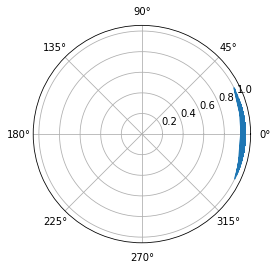

In [138]:
a = Angle(df.mc_az.values, unit=u.rad)
ax = plt.subplot(111, projection='polar')
ax.plot(a, np.ones_like(a))
# plt.hist(Angle(df.mc_az * u.rad).rad, bins=100)

In [139]:
mc_az = Angle(df.mc_az.values, unit=u.rad)
mc_alt = Angle(df.mc_alt.values, unit=u.rad)

az = Angle(df.az_prediction.values, unit=u.rad)
alt = Angle(df.alt_prediction.values, unit=u.rad)

# print(az, alt, mc_az, mc_alt)
distance = angular_separation(mc_az, mc_alt, az, alt).to('deg')
print(len(distance))

1715


(array([11., 32., 32., 34., 51., 42., 37., 29., 35., 34., 32., 50., 39.,
        38., 41., 33., 28., 20., 15., 31., 35., 29., 22., 33., 47., 40.,
        23., 38., 33., 27.]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
        1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
        2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
        3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ,
        4.16666667, 4.33333333, 4.5       , 4.66666667, 4.83333333,
        5.        ]),
 <a list of 30 Patch objects>)

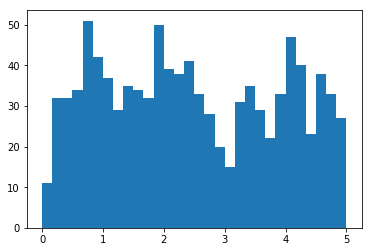

In [147]:
plt.hist(distance, range=(0, 5), bins=30)

In [145]:
np.nanpercentile(distance, 68)

5.322582478514606